# Representations with and without convolutions

As shown before, the deep decoder enables concise representations of images.

The deep decoder takes linear combinations of the channels in each layer. This is equivalent to a convolutional layer with $1\times1$ convolutions. In the paper we refrain from calling this operations $1\times1$ convolutions, since it really is a degenerate convolution better described as a multiplication.

However, it is natural to ask whether using linear combinations instead of non-degenerate convolutions (i.e., convolutions with $p\times p, p\geq 2$ kernels) performs better. Below we demonstrate that it does, albeit not by very much.

Recall that the number of parameters of the deep decoder is
$$
N(1,k) = d k^2 + 3k + 2dk.
$$
If we consider a deep decoder with $p\times p$ convolutions, then the number of parameters is:
$$
N(p,k) = p^2 (d k^2 + 3k) + 2dk.
$$
If we fix the number of channels, $k$, but increase $p$, the representation error only decreases since we decrease the number of parameters.
Therfore, we compare the representation error of a deep decoder with $p=1$ and $k=64$ (the default architecture in our paper) to a version of the deep decoder with $3\times 3$ convolutions such that the number of parameters is the same in both configurations (i.e., the number of channels is relatively smaller in the decoder with $3\times 3$ convolutions). We find that the representation of the deep decoder with $p=1$ is slighlty better (by about 1dB, depending on the image), and thus for our context linear combinations or $1\times 1$ convolutions are preferable.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pyplot as plt
import numpy as np
import numbers
import pywt
import scipy
import skimage.color as color
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage.measure import compare_psnr
import os
from PIL import Image
import PIL
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.optim
from torch.autograd import Variable

from include import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
print("num GPUs",torch.cuda.device_count())
#dtype = torch.FloatTensor

num GPUs 1


## Functions to compute the representation error

In [2]:
def rep_error_deep_decoder(img_np,k=128,convert2ycbcr=False,filter_size_up=1):
    '''
    mse obtained by representing img_np with the deep decoder
    '''
    output_depth = img_np.shape[0]
    if output_depth == 3 and convert2ycbcr:
        img = rgb2ycbcr(img_np)
    else:
        img = img_np
    img_var = np_to_var(img).type(dtype)
    
    num_channels = [k]*5
    net = decodernw(output_depth,num_channels_up=num_channels,filter_size_up=filter_size_up,upsample_first = True).type(dtype)
    rnd = 500
    numit = 20000
    rn = 0.005
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.005,
                        img_noisy_var=img_var,
                        net=net,
                        img_clean_var=img_var,
                        find_best=True,
                               )
    out_img = net(ni.type(dtype)).data.cpu().numpy()[0]
    if output_depth == 3 and convert2ycbcr:
        out_img = ycbcr2rgb(out_img)
    return psnr(out_img,img_np), out_img, num_param(net)

def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')    
        
def rep_error(img_np,k,filter_size_up=1):
    # compute representations
    psnrv, out_img_np, nparms = rep_error_deep_decoder(img_np,k=k,filter_size_up=filter_size_up)
    nchannels = img_np.shape[0]
    psnrv_wvl, out_img_np_wvl = rep_error_wavelet(img_np,ncoeff=int(nparms/nchannels))
    
    print("Compression factor: ", np.prod( img_np.shape ) / nparms )
    # plot results
    fig = plt.figure(figsize = (5,5)) # create a 5 x 5 figure 
    
    ax2 = fig.add_subplot(111)
    myimgshow(ax2,out_img_np)
    ax2.set_title( "Deep-Decoder representation, PSNR: %.2f" % psnrv )
    ax2.axis('off')
       
    plt.axis('off')
    fig.show()

In [3]:
def f(p,d,k):
    return p**2 * ( d*k*k + 3*k) + 2*d*k
print( f(1,6,64) )
print( f(3,6,22) )

25536
26994


## Convolutions for image representations




In [4]:
path = './test_data/'
img_name = "sf4_rgb"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)

shape:  [1, 22, 16, 16]
optimize with adam 0.005
Compression factor:  29.714803899342552 Actual loss 0.003675 Actual loss orig 0.003675  Noise Energy 0.000000 


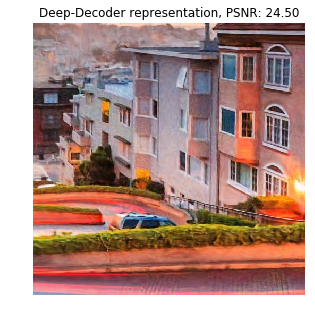

In [11]:
k = 22
filter_size_up = 3
rep_error(img_np,k,filter_size_up=filter_size_up)

shape:  [1, 64, 16, 16]
optimize with adam 0.005
Compression factor:  30.796992481203006 Actual loss 0.003301 Actual loss orig 0.003301  Noise Energy 0.000000 


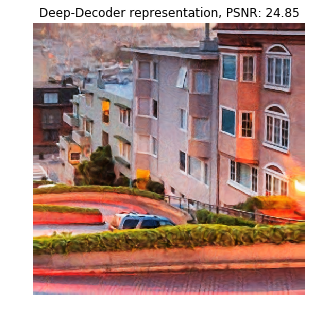

In [12]:
k = 64
filter_size_up = 1
rep_error(img_np,k,filter_size_up=filter_size_up)

shape:  [1, 43, 16, 16]
optimize with adam 0.005
Compression factor:  7.825894856255784  Actual loss 0.001578 Actual loss orig 0.001578  Noise Energy 0.000000 


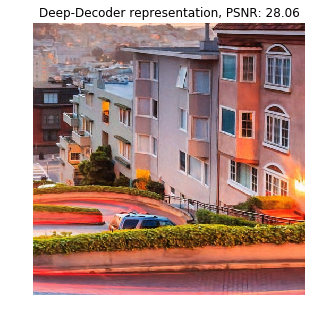

In [7]:
k = 43
filter_size_up = 3
rep_error(img_np,k,filter_size_up=filter_size_up)

shape:  [1, 129, 16, 16]
optimize with adam 0.005
Compression factor:  7.726707342234798  Actual loss 0.001498 Actual loss orig 0.001498  Noise Energy 0.000000 


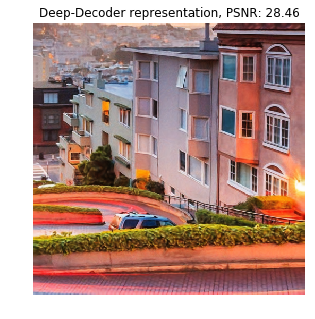

In [10]:
k = 129
filter_size_up = 1
rep_error(img_np,k,filter_size_up=filter_size_up)

shape:  [1, 89, 16, 16]
optimize with adam 0.005
Compression factor:  16.095290722662245 Actual loss 0.002302 Actual loss orig 0.002302  Noise Energy 0.000000 


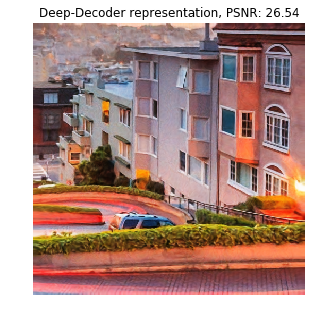

In [8]:
k = 89
filter_size_up = 1
rep_error(img_np,k,filter_size_up=filter_size_up)

shape:  [1, 30, 16, 16]
optimize with adam 0.005
Compression factor:  16.033272171253824 Actual loss 0.002550 Actual loss orig 0.002550  Noise Energy 0.000000 


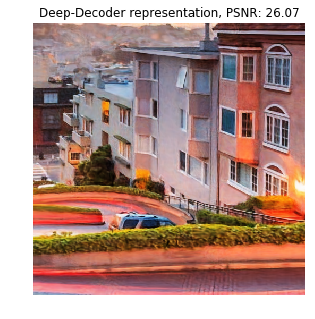

In [9]:
k = 30
filter_size_up = 3
rep_error(img_np,k,filter_size_up=filter_size_up)